In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Change directory to your working directory
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/NLP Project"

os.chdir(DATA_DIR)
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP Project'

In [ ]:
%pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
df = pd.read_csv("spoken_written_full_dataset.csv")  # Ensure dataset has 'text' and 'label' columns
df = df.dropna()  # Drop missing values if any
df = df.rename(columns={"type": "label"})  # Renames "type" column to "label"
df

,text,source,formality,label
0,only the portion of the investment that was on...,enron_emails,formal,written
1,"f oh, uh-huh. c because,",telephone_convos,informal,spoken
2,"i congratulate you, mr. president, on your ele...",un_debates,formal,spoken
3,"however, fasb would not allow goodwill amortiz...",enron_emails,formal,written
4,(b) enhanced technical capacity of eclac membe...,un_corpus,formal,written
...,...,...,...,...
2881,core value deadlines self-taught lesson deadli...,textbooks,educational,written
2882,yeah.,telephone_convos,informal,spoken
2883,the united nations human rights council and th...,un_corpus,formal,written
2884,teaming up with arkane ampnet is using the aet...,medium,semiformal,written


In [ ]:
import pandas as pd

# Select only the two required columns (e.g., "text" and "label")
selected_columns = ["text", "label"]
df_subset = df[selected_columns]

# Randomly select 500 rows with a fixed seed for reproducibility
df_sampled = df_subset.sample(n=500, random_state=42)

# Reset index for cleanliness
df_sampled = df_sampled.reset_index(drop=True)

# Display the new DataFrame
print(df_sampled.head())

                                                text    label
0  would you please provide me with some examples...  written
1  book title sealed by a kiss author ava gray de...  written
2  convention on the prohibition of the developme...  written
3  motion carries. okay. thank you, madam. item 1...   spoken
4  the voices of indigenous peoples must be heard...  written


In [ ]:
id2label = {0: "written", 1: "spoken"}
label2id = {"written": 0, "spoken": 1}

In [ ]:
df_sampled["label"] = df_sampled["label"].map(label2id)

In [ ]:
dataset = Dataset.from_pandas(df_sampled)
# Split into train/test sets
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

In [ ]:
train_dataset[0]

{'text': '9. the special rapporteur has continued to place particular emphasis on cooperation with all bodies of the united nations and other regional intergovernmental human rights organizations.',
 'label': 0}

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
train_dataset['label'][0]

0

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(train_dataset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    eval_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [ ]:
!pip install wandb

In [ ]:
! wandb login
# API KEY = 8544b034b0ba783804d4ba2d8bcdbeb3fe2de75c

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivanipuli (shivanipuli-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
from transformers import TrainingArguments

# ✅ Initialize W&B
wandb.init(project="bert-written-classification")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# ✅ Modify Training Arguments to enable logging
training_args = TrainingArguments(
    output_dir="./hugging_face_bert_classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    report_to="wandb",  # ✅ Enables logging to W&B
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    load_best_model_at_end=True,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir="./hugging_face_bert_classifier",
    run_name="bert_finetune_spoken_vs_written",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-106-eb4c7ea1fbf5>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.329788,0.870000,0.894493,0.870000,0.865493
2,No log,0.392939,0.890000,0.908060,0.890000,0.887062


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.329788,0.870000,0.894493,0.870000,0.865493
2,No log,0.392939,0.890000,0.908060,0.890000,0.887062


In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.2932603061199188, 'eval_accuracy': 0.93, 'eval_precision': 0.9377777777777777, 'eval_recall': 0.93, 'eval_f1': 0.9290341321713871, 'eval_runtime': 56.7187, 'eval_samples_per_second': 1.763, 'eval_steps_per_second': 0.123, 'epoch': 3.0}


In [ ]:
trainer.save_model("./bert_finetuned_spoken_vs_written")  # ✅ Saves the model
tokenizer.save_pretrained("./bert_finetuned_spoken_vs_written")  # ✅ Saves tokenizer

('./bert_finetuned_spoken_vs_written/tokenizer_config.json',
 './bert_finetuned_spoken_vs_written/special_tokens_map.json',
 './bert_finetuned_spoken_vs_written/vocab.txt',
 './bert_finetuned_spoken_vs_written/added_tokens.json',
 './bert_finetuned_spoken_vs_written/tokenizer.json')

In [ ]:
trainer.save_state()  # ✅ Saves optimizer, scheduler, and Trainer state

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ✅ Load Model and Tokenizer
model_path = "./bert_finetuned_spoken_vs_written"
model2 = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer2 = AutoTokenizer.from_pretrained(model_path)


In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

NameError: name 'trainer2' is not defined

In [ ]:
import torch

# ✅ Sample input for testing
text = "I think this might be a good idea."
inputs = tokenizer2(text, return_tensors="pt")

# ✅ Predict using the reloaded model
model2.eval()
with torch.no_grad():
    logits = model2(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Predicted Label: {id2label[predicted_class_id]}")


Predicted Label: spoken


In [ ]:
# ✅ Sample input for testing
text = "The contextual evidence relating to the study (often relating to academics) indicates otherwise."
inputs = tokenizer2(text, return_tensors="pt")

# ✅ Predict using the reloaded model
model2.eval()
with torch.no_grad():
    logits = model2(**inputs).logits

predicted_class_id = logits.argmax().item()
print(f"Predicted Label: {id2label[predicted_class_id]}")

Predicted Label: written


## SHAP Explainer ##

In [ ]:
import torch
import shap
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import shap
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ✅ Load the fine-tuned model and tokenizer
model_path = "./bert_finetuned_spoken_vs_written"
model2 = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer2 = AutoTokenizer.from_pretrained(model_path)

# ✅ Set model to evaluation mode (no gradients needed)
model2.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import numpy as np

# ✅ Function to return probability scores
def predict_probabilities(texts):
    inputs = tokenizer2(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        logits = model2(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probabilities


In [ ]:
sample_text = "Uh, so, like, I think we should probably head out now."
explainer = shap.Explainer(lambda x: predict_probabilities(x), masker=shap.maskers.Text(tokenizer2))

In [ ]:
shap_values = explainer(sample_text)
shap.text_plot(shap_values)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
import shap
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "./bert_finetuned_spoken_vs_written"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()

def predictor(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probabilities


Provided model function fails when applied to the provided data set.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# sample_text = ["Uh, so, like, I think we should probably head out now."]
baseline_texts = np.array(train_dataset["text"][:10], dtype=str).reshape(-1, 1)  # Explicitly set dtype=object for SHAP

explainer = shap.KernelExplainer(predictor, np.column_stack((train_dataset["text"], train_dataset["label"])))  # Dummy data for SHAP baseline
shap_values = explainer.shap_values(eval_dataset)
shap.text_plot(shap_values)
colour_test = pd.DataFrame(X_test_sample.todense())

Provided model function fails when applied to the provided data set.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
prediciton = predictor(sample_text)
prediciton

array([[0.00973942, 0.99026054]], dtype=float32)

In [ ]:
import shap
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# ✅ Load your fine-tuned BERT model and tokenizer
model_path = "./bert_finetuned_spoken_vs_written"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# ✅ Ensure model is in evaluation mode
model.eval()

# ✅ Define a function to tokenize and return model predictions
def predictor(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()
    return probabilities

# ✅ Sample test sentence
sample_text = ["Uh, so, like, I think we should probably head out now."]

# ✅ Use SHAP KernelExplainer with an empty string as background data for SHAP baseline
# Instead of using np.zeros, use an empty string or a list with an empty string as the background data.
# This is because the predictor function expects a list of strings, not a numerical array.
explainer = shap.KernelExplainer(predictor, [0]*512)
shap_values = explainer.shap_values(sample_text, nsamples=50)

# ✅ Visualize explanation
shap.text_plot(shap_values)

TypeError: Unknown type passed as data object: <class 'list'>

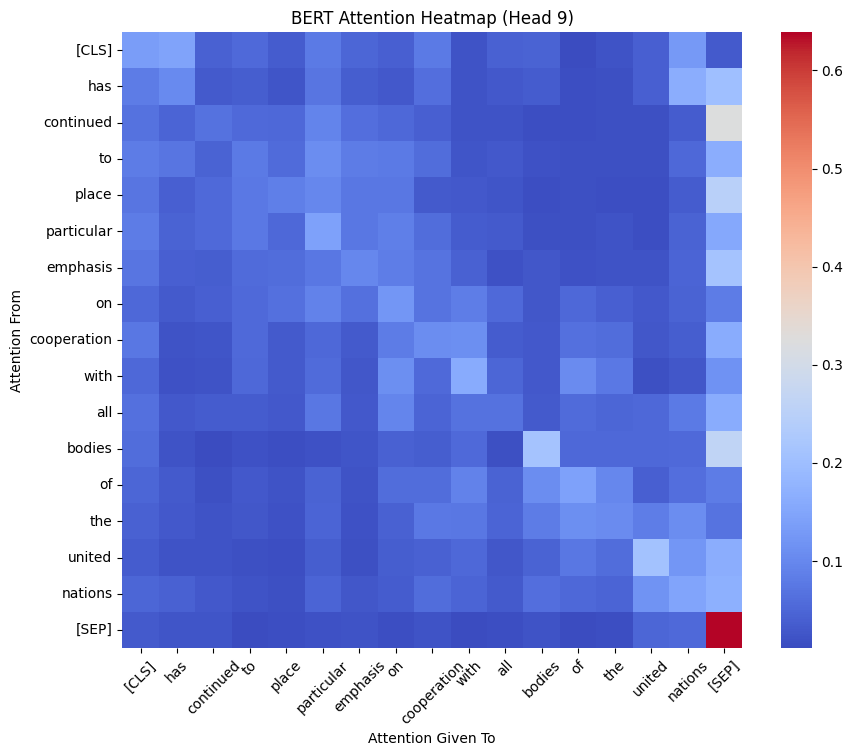

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Tokenize input
sample_text = "has continued to place particular emphasis on cooperation with all bodies of the united nations"
inputs = tokenizer(sample_text, return_tensors="pt")

# ✅ Get attention weights
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# ✅ Extract attention from last layer (select first batch element)
attention = outputs.attentions[-1][0].numpy()  # Shape: (num_heads, seq_len, seq_len)

tokens = tokens[1:10]  # Adjust range to select different portions
#attention = attention_matrix[1:10, 1:10]  # Slice matrix to match


# ✅ Select a single attention head (e.g., first head)
head_index = 9  # Choose which head to visualize
attention_matrix = attention[head_index]  # Shape: (seq_len, seq_len)

# ✅ Convert token IDs to readable words
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

# ✅ Plot the attention heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="coolwarm")
plt.xlabel("Attention Given To")
plt.ylabel("Attention From")
plt.title(f"BERT Attention Heatmap (Head {head_index})")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Extract embeddings from last hidden state
with torch.no_grad():
    inputs = tokenizer(eval_dataset['text'], return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs, output_hidden_states=True)
    embeddings = outputs.hidden_states[-1][:, 0, :].numpy()  # Extract CLS token embeddings

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)


NameError: name 'true_labels' is not defined

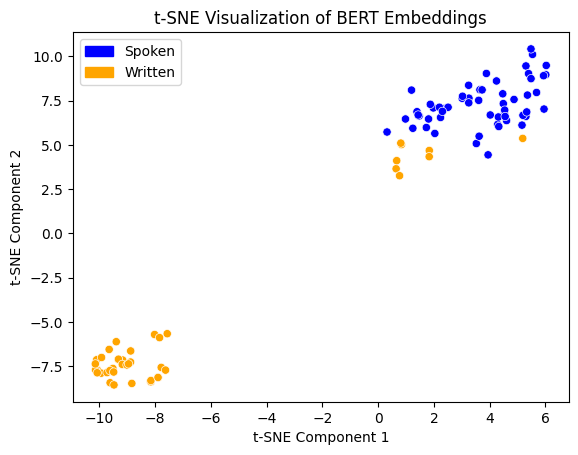

In [ ]:
import matplotlib.patches as mpatches
# Plot embeddings with labels
sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=eval_dataset["label"], palette=["blue", "orange"])
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of BERT Embeddings")
spoken_patch = mpatches.Patch(color="blue", label="Spoken")
written_patch = mpatches.Patch(color="orange", label="Written")

plt.legend(handles=[spoken_patch, written_patch])
plt.show()

In [ ]:
print(id2label[train_dataset[0]["label"]], train_dataset[0]["text"])

written 9. the special rapporteur has continued to place particular emphasis on cooperation with all bodies of the united nations and other regional intergovernmental human rights organizations.


In [ ]:
import pandas as pd

# Select only the two required columns (e.g., "text" and "label")
selected_columns = ["text", "label", "source"]
df_subset = df[selected_columns]

# Randomly select 500 rows with a fixed seed for reproducibility
df_sampled = df_subset.sample(n=500, random_state=42)

# Reset index for cleanliness
df_sampled = df_sampled.reset_index(drop=True)

# Display the new DataFrame
print(df_sampled.head())
df_sampled["label"] = df_sampled["label"].map(label2id)
dataset = Dataset.from_pandas(df_sampled)
# Split into train/test sets
dataset = dataset.train_test_split(test_size=0.2)
eval_dataset = dataset["test"]

                                                text    label  \
0  would you please provide me with some examples...  written   
1  book title sealed by a kiss author ava gray de...  written   
2  convention on the prohibition of the developme...  written   
3  motion carries. okay. thank you, madam. item 1...   spoken   
4  the voices of indigenous peoples must be heard...  written   

              source  
0       enron_emails  
1          textbooks  
2          un_corpus  
3  business_meetings  
4          un_corpus  


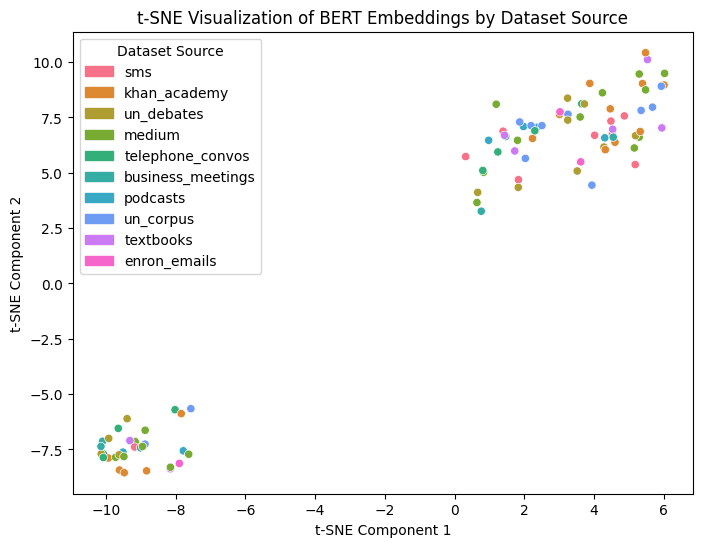

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette for different dataset sources
unique_sources = set(eval_dataset["source"])  # Assuming "source" column exists
palette = sns.color_palette("husl", len(unique_sources))  # Generate distinct colors

# Plot embeddings with dataset sources as labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=eval_dataset["source"], palette=palette)

# Labels and title
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of BERT Embeddings by Dataset Source")

# Create legend dynamically based on dataset sources
legend_patches = [mpatches.Patch(color=palette[i], label=source) for i, source in enumerate(unique_sources)]
plt.legend(handles=legend_patches, title="Dataset Source")

# Show plot
plt.show()